This notebook provides examples to go along with the [textbook](http://manipulation.csail.mit.edu/robot.html).  I recommend having both windows open, side-by-side!

In [1]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    LeafSystem,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    StateInterpolatorWithDiscreteDerivative,
)
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.utils import RenderDiagram

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://4e4bcb41-cafd-436c-bda4-33dbe7202b60.deepnoteproject.com/7003/


# Controlling the iiwa with an allegro hand

The `MakeHardwareStation` code sets everything up assuming that you have an iiwa with a Schunk WSG gripper. What if you want to use the allegro hand instead? Then it probably makes sense implement the basic components of `MakeHardwareStation` yourself.

The simplest approach, which will be suitable for simulation, will be to use one `InverseDynamicsController` that treats the iiwa + Allegro as a single robot to control. If you want to run on the actual iiwa hardware, then we can do better (create two controllers, one for the iiwa which assumes an equivalent mass for the hand in a nominal fixed position + another controller for the hand), but that is not necessary to start.

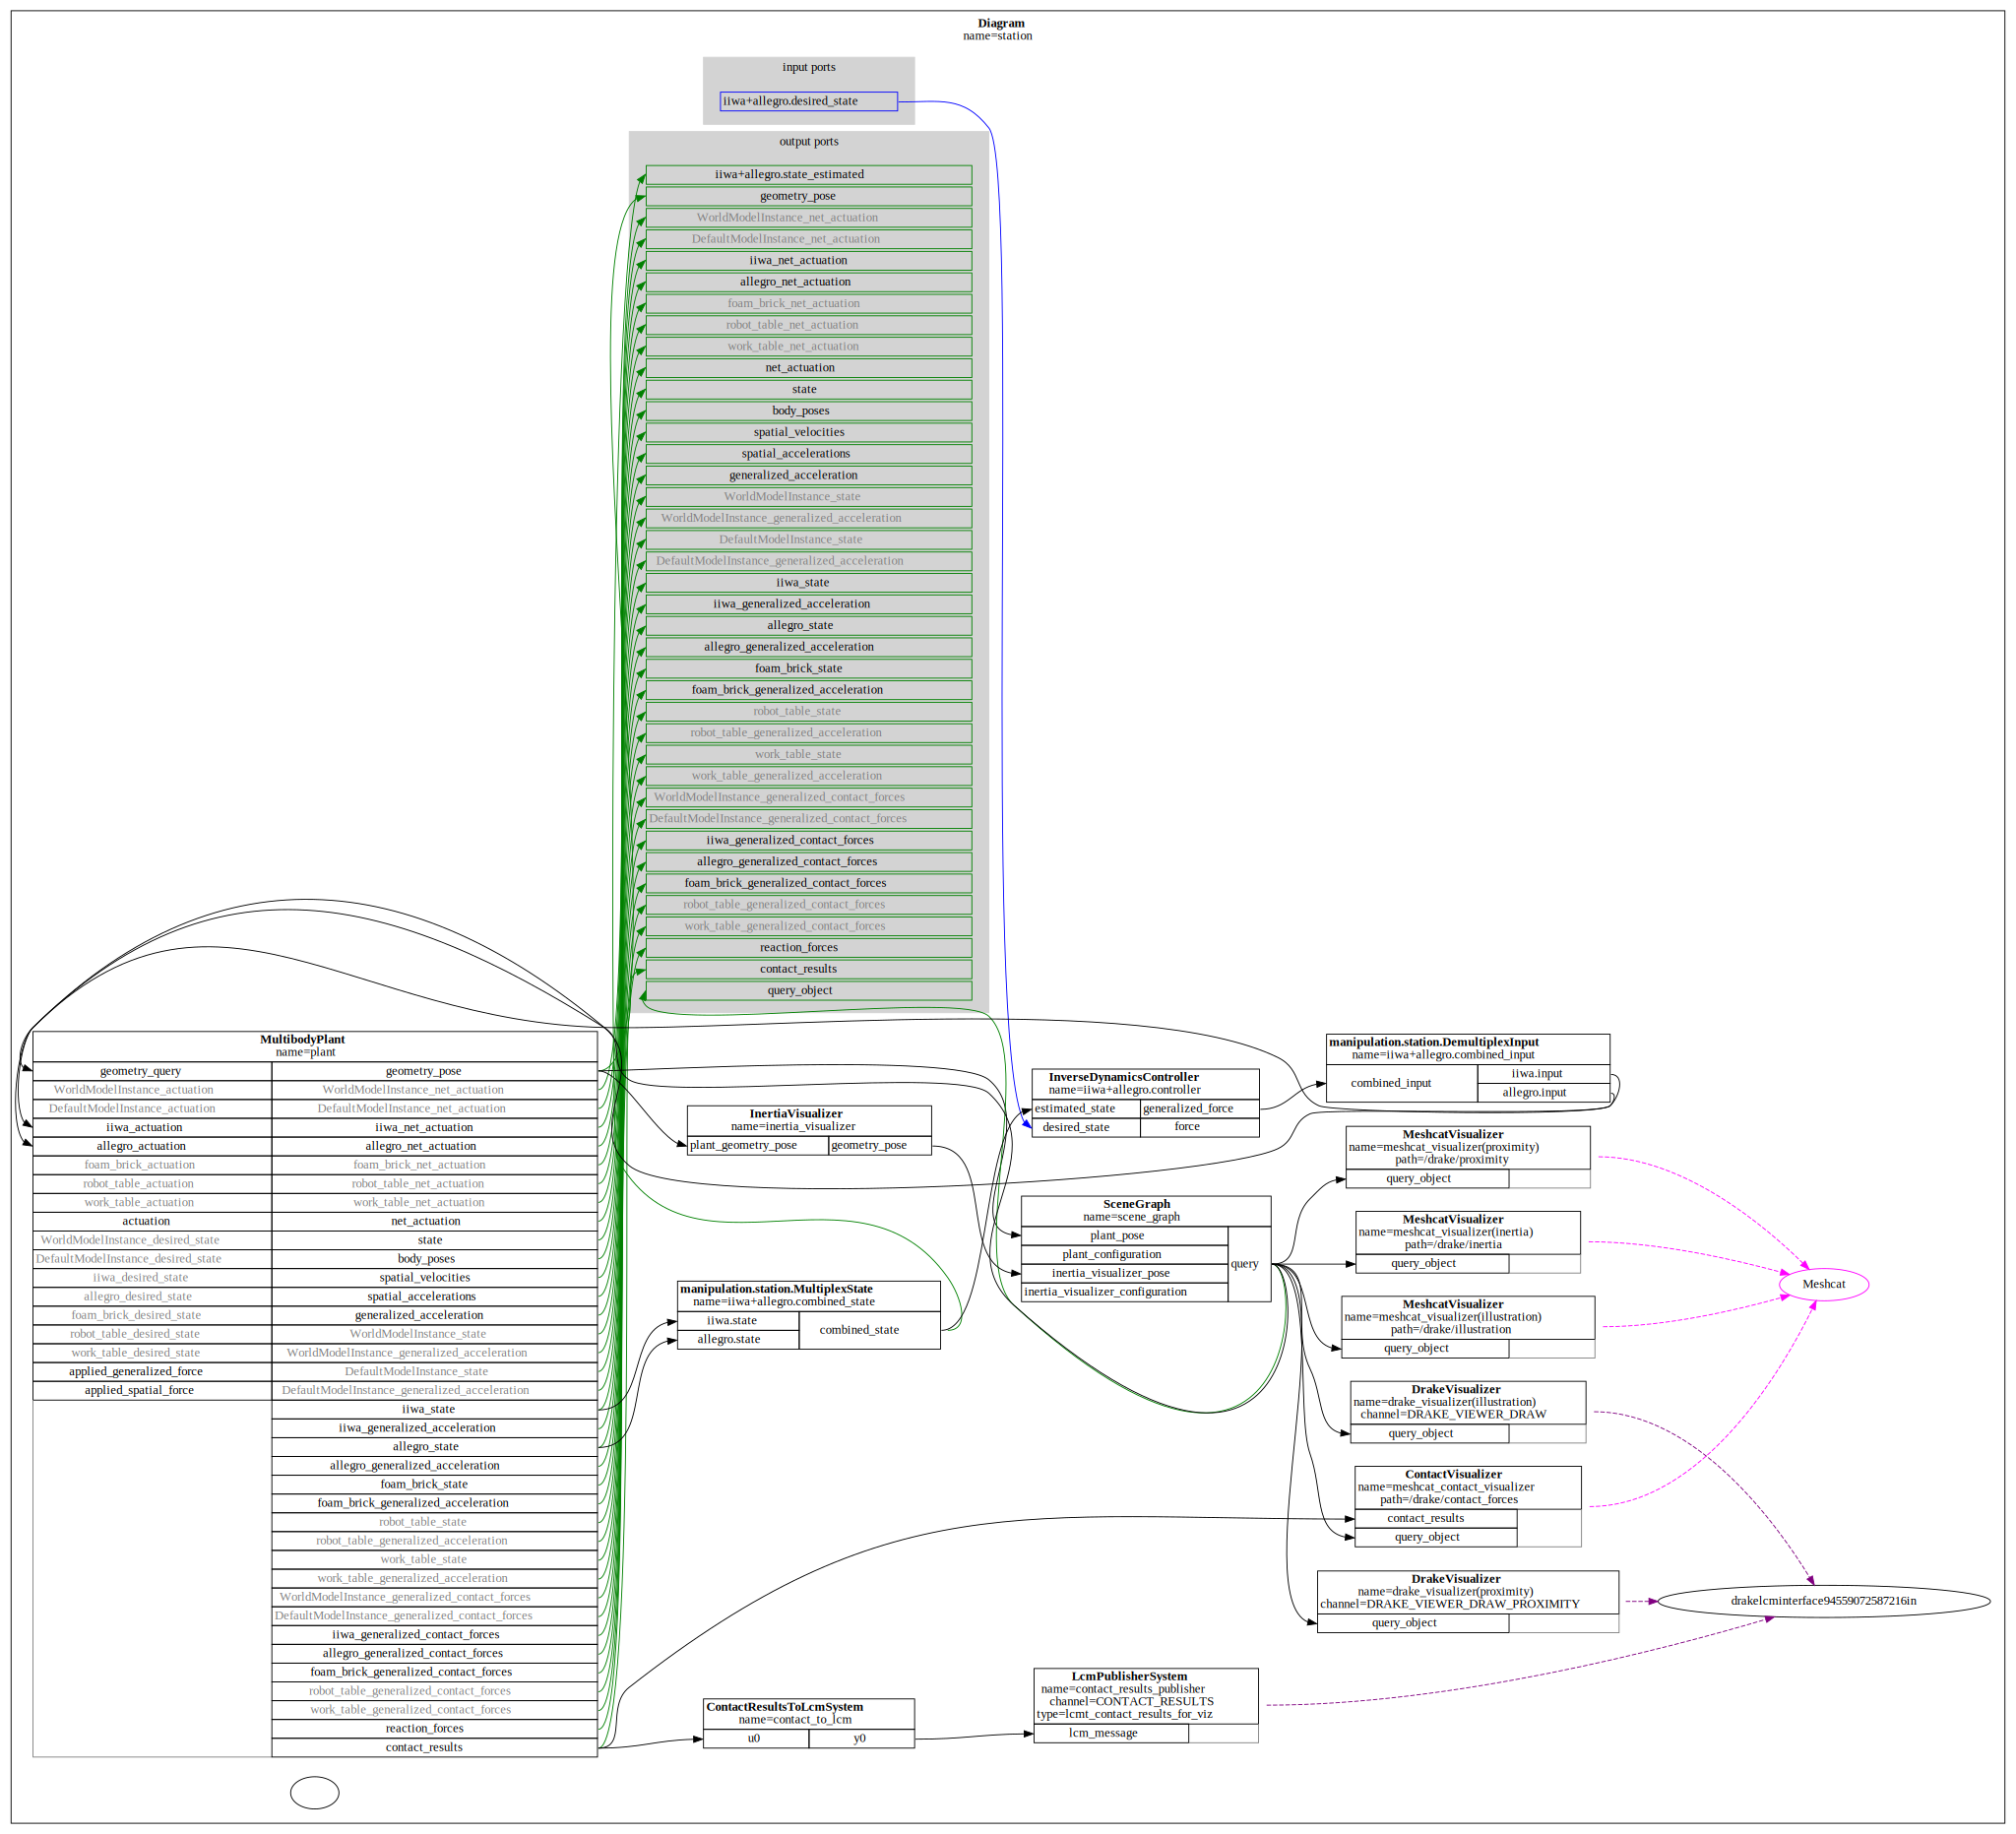

In [9]:
scenario_data = """
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: allegro
    file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: allegro::hand_root
    X_PC:
        translation: [0, 0, 0.05]
        rotation: !Rpy { deg: [0, 0, 0]}
# And now the environment:
- add_model:
    name: foam_brick
    file: package://drake/examples/manipulation_station/models/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0.6, 0, 0]
- add_model:
    name: robot_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: robot_table::link
    X_PC:
        translation: [0, 0, -0.7645]
- add_model:
    name: work_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: work_table::link
    X_PC:
        translation: [0.75, 0, -0.7645]
model_drivers:
    iiwa+allegro: !InverseDynamicsDriver {}
"""

scenario = load_scenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat)

RenderDiagram(station, max_depth=1)

simulator = Simulator(station)
context = simulator.get_mutable_context()

x0 = station.GetOutputPort("iiwa+allegro.state_estimated").Eval(context)
station.GetInputPort("iiwa+allegro.desired_state").FixValue(context, x0)

# Confirm that simulation works:
simulator.AdvanceTo(0.1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e4bcb41-cafd-436c-bda4-33dbe7202b60' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>